# Sensitivity Analyisis of Game Theoretic Solution

In [7]:
import pandas as pd
import numpy as np
##
from scipy.stats import uniform, beta, bernoulli
import prob1_mod as p
from mcmc import mcmc_adg, mcmc_ara
import matplotlib.pyplot as plt
from plotnine import *

ModuleNotFoundError: No module named 'prob1_mod'

## Parameters

In [2]:
K = 10000 ## Number of perturbations
iters=10000 ## Number of iterations for MC approximation

## Perturbations

### Perturbations on RP coefficient

In [190]:
e_values = uniform.rvs(0, 2, size=K) ##  Perturbations on RP coefficient

### Perturbations on probabilities

In [191]:
def exp_beta(alpha, beta):
    return alpha / (alpha + beta)
##
def beta_params(mu, var):
    alpha = ( (1-mu)/var - 1/mu ) * mu**2
    beta = ( 1/mu - 1 )*alpha
    return alpha, beta

means = exp_beta(p.alpha_values, p.beta_values)
k = 0.2

alpha_perturbed, beta_perturbed =  beta_params(means, k*means)

def perturb_probabilities(k, p_original):
    p_pert = np.zeros_like(p_original)
    means = p_original[:,1]
    alpha_pert, beta_pert = beta_params(means, k* means)
    perturba = np.zeros_like(alpha_pert)
    for i in range( len(alpha_pert) ):
        perturba[i] = beta.rvs( alpha_pert[i], beta_pert[i] ) 
    ##    
    p_pert[:,1] = perturba
    p_pert_f = lambda d, a: p_pert[d,a]
    return p_pert_f

In [192]:
#def a_prob(d, a, size=1):
#    p_pert = beta.rvs(a=alpha_perturbed[d], b=beta_perturbed[d])
#    return bernoulli.rvs(p=p_pert, size=size) if a==1 else np.zeros(size, dtype=int)

## Main Loop

In [193]:
def compute_exact_solution(d_values, a_values, d_ut, a_ut, p):
    ##
    def exp_util_def(d, a):
        return p(d,a) * d_ut(d, 1) + (1 - p(d,a)) * d_ut(d, 0)
    ##
    def exp_util_att(d, a):
        return p(d,a) * a_ut(a, 1) + (1 - p(d,a) ) * a_ut(a, 0)
    
    a_opt = np.zeros_like( d_values )
    psi_d = np.zeros( len(d_values) )
    
    for i, d in enumerate(d_values):
        ##
        if exp_util_att(d, a_values[0]) > exp_util_att(d, a_values[1]):
            a_opt[i] = a_values[0]
        else:
            a_opt[i] = a_values[1]
        ##
        psi_d[i] = exp_util_def(d, a_opt[i])
        
    d_opt = np.argmax(psi_d)
    return d_opt, psi_d[d_opt]

### Solve original problem

In [194]:
pr = lambda d, a: p.p1[d,a]
d_opt, psi_d_opt = compute_exact_solution(p.d_values, p.a_values, p.d_util, p.a_util, pr)
print(d_opt, psi_d_opt)

8 -1.1972173631218102


### Solve perturbed problems

In [195]:
k = 0.001
d_p = np.zeros(K)
psi_p = np.zeros(K)

In [196]:
for i, e in enumerate(e_values):
    a_util_pert = lambda a, theta: p.ua(p.ca[a, theta], e=e) ## Perturbed Attacker's Utility
    p_pert = perturb_probabilities(k, p.p1) ## Perturbed Attacker's Probabilities
    d_p[i], psi_p[i] = compute_exact_solution(p.d_values, p.a_values, p.d_util, a_util_pert, p_pert)
##


## Analysis

In [270]:
np.max( abs( psi_p - psi_d_opt ) ) / abs(psi_d_opt)

0.42463225638727925

In [198]:
d_p[ np.argmax( abs(psi_p - psi_d_opt))  ]

9.0

In [199]:
res = pd.DataFrame({"pert_dec" : d_p.astype("int"), "pert_util" : psi_d_opt})

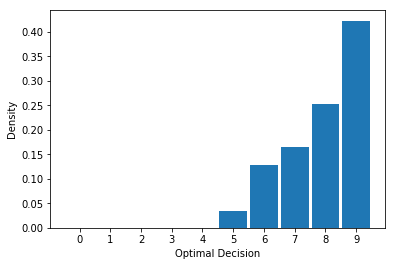

In [263]:
bins = np.arange(0, d_p.max() + 1.5) - 0.5

# then you plot away
fig, ax = plt.subplots()
_ = ax.hist(d_p, bins, density=1, rwidth=0.9)

ax.set_xlabel('Optimal Decision')
ax.set_ylabel('Density')
#
ax.set_xticks(np.arange(0,10))
#
fig.savefig('../img/hist_sa2.eps', format='eps', dpi=600)


In [269]:
np.sum(res.pert_dec == 7)/len(res)

0.1642